# Natural Language Processing with Disaster Tweets

In [1]:
!pip install transformers tensorflow

import numpy as np 
import pandas as pd 
import tensorflow as tf
import keras as keras
import matplotlib.pyplot as plt

print("TensorFlow version:", tf.__version__)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

TensorFlow version: 2.12.0


# Load the Disaster Tweets
Let's have a look at the train and test dataset.

They contain:
- id
- keyword: A keyword from that tweet (although this may be blank!)
- location: The location the tweet was sent from (may also be blank)
- text: The text of a tweet
- target: 1 if the tweet is a real disaster or 0 if not (only in train - NOT in test) 

In [9]:
df_train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
df_test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

print('Training Set Shape = {}'.format(df_train.shape))
print('Test Set Shape = {}'.format(df_test.shape))

df_train.head()

Training Set Shape = (7613, 5)
Test Set Shape = (3263, 4)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


# Explore the dataset

Train Length Stat
count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

Test Length Stat
count    3263.000000
mean      102.108183
std        33.972158
min         5.000000
25%        78.000000
50%       109.000000
75%       134.000000
max       151.000000
Name: length, dtype: float64


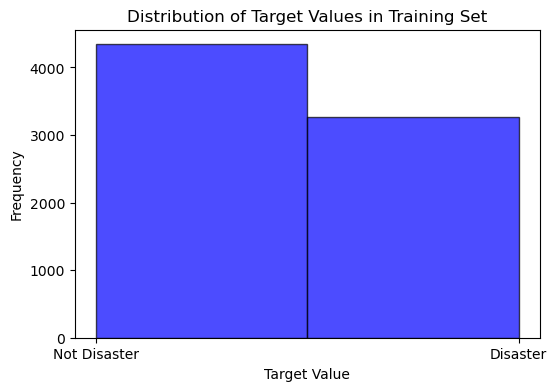

In [12]:
df_train["length"] = df_train["text"].apply(lambda x : len(x))
df_test["length"] = df_test["text"].apply(lambda x : len(x))

print("Train Length Stat")
print(df_train["length"].describe())
print()

print("Test Length Stat")
print(df_test["length"].describe())

# Plot a histogram of the target values
plt.figure(figsize=(6, 4))
plt.hist(df_train['target'], bins=2, edgecolor='k', color='blue', alpha=0.7)
plt.title('Distribution of Target Values in Training Set')
plt.xticks([0, 1], ['Not Disaster', 'Disaster'])
plt.xlabel('Target Value')
plt.ylabel('Frequency')
plt.show()

# RNN Approach 

Recurrent Neural Network (RNN) models are great for capturing relationships and dependencies in data which is why it is a great choice for looking at Tweets where the context is crucial for understanding the correct label. Is it a true disaster or another form of communication? That primiarily comes down to context and being able to understand the underlying emotion of text. 


# Data Preparation steps 
Some of the key steps will be to prepare the text properly. That includes tokenizing the text but also removing special characters and URL's that will just be noisy and not helpful in understanding the text. It is also important to pad the tweets so everything will be the same size. This is important for consistency but it can also cause noise since extra blank space isn't adding any new information. 

Epoch 1/15
96/96 [==============================] - 19s 151ms/step - loss: 0.6858 - accuracy: 0.5644 - val_loss: 0.6789 - val_accuracy: 0.5850
Epoch 2/15
96/96 [==============================] - 14s 144ms/step - loss: 0.6307 - accuracy: 0.6593 - val_loss: 0.6029 - val_accuracy: 0.7209
Epoch 3/15
96/96 [==============================] - 14s 143ms/step - loss: 0.5437 - accuracy: 0.7680 - val_loss: 0.5891 - val_accuracy: 0.7262
Epoch 4/15
96/96 [==============================] - 14s 144ms/step - loss: 0.5440 - accuracy: 0.7634 - val_loss: 0.5787 - val_accuracy: 0.7400
Epoch 5/15
96/96 [==============================] - 14s 144ms/step - loss: 0.5045 - accuracy: 0.7952 - val_loss: 0.5824 - val_accuracy: 0.7459
Epoch 6/15
96/96 [==============================] - 14s 142ms/step - loss: 0.4737 - accuracy: 0.8131 - val_loss: 0.5806 - val_accuracy: 0.7498
Epoch 7/15
96/96 [==============================] - 14s 146ms/step - loss: 0.4439 - accuracy: 0.8327 - val_loss: 0.5904 - val_accuracy: 0.7538

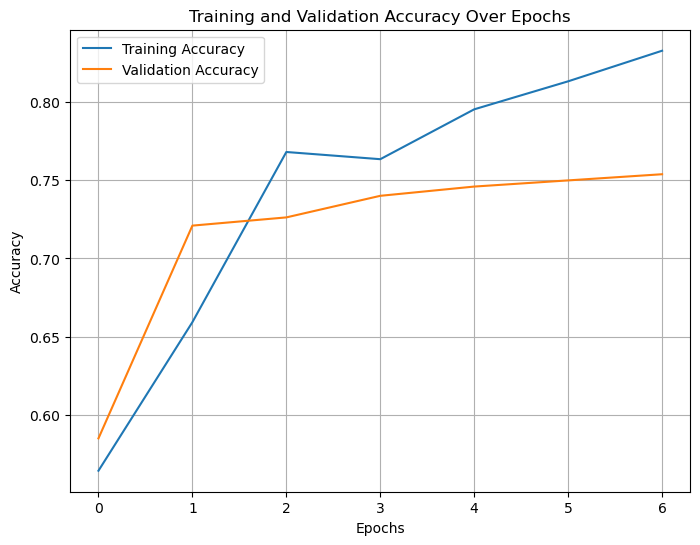

In [18]:
# Sequential RNN model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

# Load datasets
df_train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
df_test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

# Check for missing values and fill them
df_train['keyword'] = df_train['keyword'].fillna('')
df_train['location'] = df_train['location'].fillna('')
df_train['text'] = df_train['text'].fillna('')
df_test['keyword'] = df_test['keyword'].fillna('')
df_test['location'] = df_test['location'].fillna('')
df_test['text'] = df_test['text'].fillna('')

# Preprocess text
import re
def preprocess_text(text):
    text = re.sub(r"http\S+", "", text)  # Remove URLs
    text = re.sub(r"#(\w+)", r"\1", text)  # Remove hashtags
    text = re.sub(r"[^A-Za-z0-9\s]", "", text)  # Remove special characters
    text = text.lower().strip()  # Convert to lowercase and strip spaces
    return text

df_train['text'] = df_train['text'].apply(preprocess_text)
df_test['text'] = df_test['text'].apply(preprocess_text)

# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train['text'])
vocab_size = len(tokenizer.word_index) + 1

x_train = tokenizer.texts_to_sequences(df_train['text'])
x_test = tokenizer.texts_to_sequences(df_test['text'])

# Pad sequences
max_length = 50 
x_train = pad_sequences(x_train, maxlen=max_length, padding='post')
x_test = pad_sequences(x_test, maxlen=max_length, padding='post')

# Prepare target values
y_train = df_train['target']

# Train-validation split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=12)

# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 100, input_length=max_length),
    tf.keras.layers.LSTM(128, dropout=0.2, return_sequences=True),
    tf.keras.layers.LSTM(64, dropout=0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Fit the model with Early Stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=15, 
    batch_size=64,
    callbacks=[early_stopping],
    verbose=1
)

# Plot training and validation accuracy over epochs
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

In [19]:
# Generate Submission File 

# Predict on test data
predictions = model.predict(x_test)
predicted_labels = (predictions > 0.5).astype(int)

# Prepare for submission
df_test['target'] = predicted_labels
submission = df_test[['id', 'target']]
submission.to_csv('/kaggle/working/submission.csv', index=False)

102/102 [==============================] - 4s 33ms/step


# Evaluation 
Solid start! The test result got a .78 accuracy in Kaggle. Let's try a few improvements: 

1. Increase epochs from 10 to 20 (it was very fast so should be able to handle this)
2. Increase the dropout rate from 0.2 to 0.3
3. Increase batch size from 64 to 128 for smoother convergence

Round 2 feedback - yikes these changes did not help! lower accuracy and much choppier values over the epochs. 

Round 3 changes: 
1. Go back to batch size 64 but add early stopping
2. Try 15 epochs (in the middle)
3. Dropout back to 0.2

Round 3 feeback - no notable changes here, the test result was still .75. The graph smoothed out for convergence but the additional epochs and early stopping ultimately didn't show improvement from the first attempt! 